🔍 Hyperparameter tuning on validation set:
n_estimators=100, max_depth=10, split=2, leaf=1 → Balanced Accuracy: 0.7949
n_estimators=100, max_depth=10, split=2, leaf=2 → Balanced Accuracy: 0.7969
n_estimators=100, max_depth=10, split=5, leaf=1 → Balanced Accuracy: 0.8021
n_estimators=100, max_depth=10, split=5, leaf=2 → Balanced Accuracy: 0.8027
n_estimators=100, max_depth=20, split=2, leaf=1 → Balanced Accuracy: 0.8652
n_estimators=100, max_depth=20, split=2, leaf=2 → Balanced Accuracy: 0.8652
n_estimators=100, max_depth=20, split=5, leaf=1 → Balanced Accuracy: 0.8613
n_estimators=100, max_depth=20, split=5, leaf=2 → Balanced Accuracy: 0.8574
n_estimators=100, max_depth=None, split=2, leaf=1 → Balanced Accuracy: 0.8796
n_estimators=100, max_depth=None, split=2, leaf=2 → Balanced Accuracy: 0.8652
n_estimators=100, max_depth=None, split=5, leaf=1 → Balanced Accuracy: 0.8717
n_estimators=100, max_depth=None, split=5, leaf=2 → Balanced Accuracy: 0.8678
n_estimators=200, max_depth=10, split

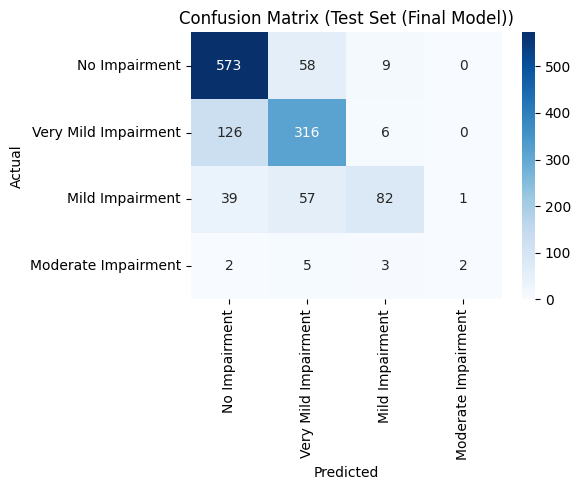

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# --- Load Datasets ---
df = pd.read_csv("train_features_scaled.csv")
val_df = pd.read_csv("val_features_scaled.csv")
test_df = pd.read_csv("test_features_scaled.csv")

# --- Feature Selection ---
X_all = df.drop(columns=["label", "label_name"], errors="ignore")
y_all = df["label"]

f_scores, _ = f_classif(X_all, y_all)
mi_scores = mutual_info_classif(X_all, y_all, random_state=42)

f_df = pd.DataFrame({"Feature": X_all.columns, "F_score": f_scores})
mi_df = pd.DataFrame({"Feature": X_all.columns, "MI_Score": mi_scores})

top_f = set(f_df.nlargest(120, "F_score")["Feature"])
top_mi = set(mi_df.nlargest(120, "MI_Score")["Feature"])
core_features = list(top_f & top_mi)

# --- Extract Features and Labels ---
X_train = df[core_features]
y_train = df["label"]
X_val = val_df[core_features]
y_val = val_df["label"]
X_test = test_df[core_features]
y_test = test_df["label"]

# --- Scale Features (optional for RF, kept for compatibility) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Manual Grid Search using Validation Set ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

best_score = 0
best_params = {}

print("🔍 Hyperparameter tuning on validation set:")
for n, d, split, leaf in product(param_grid['n_estimators'],
                                 param_grid['max_depth'],
                                 param_grid['min_samples_split'],
                                 param_grid['min_samples_leaf']):
    model = RandomForestClassifier(
        n_estimators=n,
        max_depth=d,
        min_samples_split=split,
        min_samples_leaf=leaf,
        class_weight={0: 1, 1: 3, 2: 5, 3: 9},  # like SVC weights
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)
    val_pred = model.predict(X_val_scaled)
    val_score = balanced_accuracy_score(y_val, val_pred)
    print(f"n_estimators={n}, max_depth={d}, split={split}, leaf={leaf} → Balanced Accuracy: {val_score:.4f}")
    if val_score > best_score:
        best_score = val_score
        best_params = {
            'n_estimators': n,
            'max_depth': d,
            'min_samples_split': split,
            'min_samples_leaf': leaf
        }

print("\n✅ Best Params from validation set:")
print(best_params)
print(f"Best Validation Balanced Accuracy: {best_score:.4f}")

# --- Combine Train + Val for Final Training ---
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])
X_combined_scaled = scaler.fit_transform(X_combined)

# --- Train Final Model on Combined Data ---
clf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight={0: 1, 1: 3, 2: 5, 3: 9},
    random_state=42,
    n_jobs=-1
)

clf.fit(X_combined_scaled, y_combined)

# --- Evaluation Utility ---
label_map = {
    0: "No Impairment",
    1: "Very Mild Impairment",
    2: "Mild Impairment",
    3: "Moderate Impairment"
}

def evaluate_set(X, y, dataset_name="Set"):
    y_pred = clf.predict(X)
    print(f"\n🧪 {dataset_name} Performance")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map.values(), digits=4))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# --- Evaluate Final Model ---
X_test_final_scaled = scaler.transform(X_test)
evaluate_set(X_test_final_scaled, y_test, "Test Set (Final Model)")
